# TODO

* Evolve non-parametric test that works for many different distributions (normal, uniform, exponential, etc.)

# Set up the GP algorithm and experiment

In [2]:
import sys
import numpy as np
import scipy.stats
import operator
import itertools
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

np.seterr(divide='ignore')

#def runGA():
# Generate the distributions to be used in the GP optimization process
# - Normal distribution
# - Equal variance
# - Differing means

# Sample distribution for test power metric
# Index by: [sample number (0-29)]
sig_diff_samples_0v1_same_std = np.random.normal(loc=20, scale=1, size=(30, 100))
sig_diff_samples_1v0_same_std = np.random.normal(loc=21, scale=1, size=(30, 100))

sig_diff_samples_0v2_same_std = np.random.normal(loc=30, scale=2, size=(30, 100))
sig_diff_samples_2v0_same_std = np.random.normal(loc=32, scale=2, size=(30, 100))

sig_diff_samples_0v4_same_std = np.random.normal(loc=40, scale=4, size=(30, 100))
sig_diff_samples_4v0_same_std = np.random.normal(loc=44, scale=4, size=(30, 100))

# Sample distributions for scale invariance metric
sig_diff_samples_0v10_same_std = sig_diff_samples_0v1_same_std * 10.
sig_diff_samples_10v0_same_std = sig_diff_samples_1v0_same_std * 10.

sig_diff_samples_0v100_same_std = sig_diff_samples_0v1_same_std * 100.
sig_diff_samples_100v0_same_std = sig_diff_samples_1v0_same_std * 100.

# Index by: [group (0/1)][sample number (0-29)]
null_samples_0v1_same_std = [[], []]
for dist1, dist2 in zip(sig_diff_samples_0v1_same_std, sig_diff_samples_1v0_same_std):
    both_dist = np.copy(np.append(dist1, dist2))
    np.random.shuffle(both_dist)
    dist1_sample = both_dist[:int(len(both_dist) / 2.)]
    dist2_sample = both_dist[int(len(both_dist) / 2.):]
    null_samples_0v1_same_std[0].append(dist1_sample)
    null_samples_0v1_same_std[1].append(dist2_sample)
null_samples_0v1_same_std = np.array(null_samples_0v1_same_std)

null_samples_0v2_same_std = [[], []]
for dist1, dist2 in zip(sig_diff_samples_0v2_same_std, sig_diff_samples_2v0_same_std):
    both_dist = np.copy(np.append(dist1, dist2))
    np.random.shuffle(both_dist)
    dist1_sample = both_dist[:int(len(both_dist) / 2.)]
    dist2_sample = both_dist[int(len(both_dist) / 2.):]
    null_samples_0v2_same_std[0].append(dist1_sample)
    null_samples_0v2_same_std[1].append(dist2_sample)
null_samples_0v2_same_std = np.array(null_samples_0v2_same_std)

null_samples_0v4_same_std = [[], []]
for dist1, dist2 in zip(sig_diff_samples_0v4_same_std, sig_diff_samples_4v0_same_std):
    both_dist = np.copy(np.append(dist1, dist2))
    np.random.shuffle(both_dist)
    dist1_sample = both_dist[:int(len(both_dist) / 2.)]
    dist2_sample = both_dist[int(len(both_dist) / 2.):]
    null_samples_0v4_same_std[0].append(dist1_sample)
    null_samples_0v4_same_std[1].append(dist2_sample)
null_samples_0v4_same_std = np.array(null_samples_0v4_same_std)

# GP tree: takes two arrays as input, returns a test staistic
pset = gp.PrimitiveSetTyped('MAIN', [np.ndarray, np.ndarray], float)
pset.renameArguments(ARG0='x1')
pset.renameArguments(ARG1='x2')

pset.addPrimitive(np.sqrt, [np.ndarray], np.ndarray, name='array_sqrt')
pset.addPrimitive(np.square, [np.ndarray], np.ndarray, name='array_square')
pset.addPrimitive(np.abs, [np.ndarray], np.ndarray, name='array_abs')

# Statistics derived from the array
pset.addPrimitive(np.mean, [np.ndarray], float, name='array_mean')
pset.addPrimitive(np.median, [np.ndarray], float, name='array_median')
pset.addPrimitive(np.min, [np.ndarray], float, name='array_min')
pset.addPrimitive(np.max, [np.ndarray], float, name='array_max')
pset.addPrimitive(np.std, [np.ndarray], float, name='array_std')
pset.addPrimitive(np.var, [np.ndarray], float, name='array_var')
pset.addPrimitive(np.size, [np.ndarray], float, name='array_size')
pset.addPrimitive(np.sum, [np.ndarray], float, name='array_sum')
pset.addPrimitive(scipy.stats.sem, [np.ndarray], float, name='array_stderr')

# Mathematical operators with single values
def protected_div(left, right):
    try:
        return float(left) / float(right)
    except ZeroDivisionError:
        return 1.

pset.addPrimitive(operator.add, [float, float], float, name='float_add')
pset.addPrimitive(operator.sub, [float, float], float, name='float_sub')
pset.addPrimitive(operator.mul, [float, float], float, name='float_mul')
pset.addPrimitive(protected_div, [float, float], float, name='float_div')
pset.addPrimitive(np.sqrt, [float], float, name='float_sqrt')
pset.addPrimitive(np.square, [float], float, name='float_square')
pset.addPrimitive(np.abs, [float], float, name='float_abs')

# Mathematical operators on the array with a single value
pset.addPrimitive(np.add, [np.ndarray, float], np.ndarray, name='array_add_float')
pset.addPrimitive(np.subtract, [np.ndarray, float], np.ndarray, name='array_sub_float')
pset.addPrimitive(np.multiply, [np.ndarray, float], np.ndarray, name='array_mul_float')
pset.addPrimitive(np.divide, [np.ndarray, float], np.ndarray, name='array_div_float')

# Terminals
pset.addTerminal(1.0, float)

creator.create('FitnessMulti', base.Fitness, weights=(1., -1., -1.))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=4)

"""
def return_ttest():
    return creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_stderr(x1), array_stderr(x2)))', pset)
    #return creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))', pset)

toolbox.register('individual', return_ttest)
"""
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

total_skipped = 0
total_cache_lookups = 0
solution_cache = {}

def evaluate_individual(individual):
    global total_skipped
    global total_cache_lookups
    global solution_cache
    
    if str(individual) in solution_cache:
        total_cache_lookups += 1
        return solution_cache[str(individual)]

    func = toolbox.compile(expr=individual)

    # First fitness component:
    #     - Test statistic for sig diff means should be well outside the null distribution
    #     - Test statistic for non sig diff means should be in the middle of the null distribution
    ts_0v1_same_std = []
    ts_0v2_same_std = []
    ts_0v4_same_std = []
    ts_0v10_same_std = []
    ts_0v100_same_std = []
    ts_null_0v1_same_std = []
    ts_null_0v2_same_std = []
    ts_null_0v4_same_std = []

    # Sig diff sample comparisons
    for sample1, sample2 in zip(sig_diff_samples_0v1_same_std, sig_diff_samples_1v0_same_std):
        ts_0v1_same_std.append(func(sample1, sample2))
        ts_0v1_same_std.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v2_same_std, sig_diff_samples_2v0_same_std):
        ts_0v2_same_std.append(func(sample1, sample2))
        ts_0v2_same_std.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v4_same_std, sig_diff_samples_4v0_same_std):
        ts_0v4_same_std.append(func(sample1, sample2))
        ts_0v4_same_std.append(func(sample2, sample1))
    
    for sample1, sample2 in zip(sig_diff_samples_0v10_same_std, sig_diff_samples_10v0_same_std):
        ts_0v10_same_std.append(func(sample1, sample2))
        ts_0v10_same_std.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
        ts_0v100_same_std.append(func(sample1, sample2))
        ts_0v100_same_std.append(func(sample2, sample1))

    # Null sample comparisons
    for sample1, sample2 in zip(null_samples_0v1_same_std[0], null_samples_0v1_same_std[1]):
        ts_null_0v1_same_std.append(func(sample1, sample2))
        ts_null_0v1_same_std.append(func(sample2, sample1))

    for sample1, sample2 in zip(null_samples_0v2_same_std[0], null_samples_0v2_same_std[1]):
        ts_null_0v2_same_std.append(func(sample1, sample2))
        ts_null_0v2_same_std.append(func(sample2, sample1))

    for sample1, sample2 in zip(null_samples_0v4_same_std[0], null_samples_0v4_same_std[1]):
        ts_null_0v4_same_std.append(func(sample1, sample2))
        ts_null_0v4_same_std.append(func(sample2, sample1))

    all_dists = (ts_0v1_same_std + ts_0v2_same_std + ts_0v4_same_std +
                 ts_0v10_same_std + ts_0v100_same_std +
                 ts_null_0v1_same_std + ts_null_0v2_same_std + ts_null_0v4_same_std)

    # If the solution produces NaN or inf values OR there are too few unique values OR the evolved test doesn't include both distributions, then throw it out
    if np.any(np.isnan(all_dists)) or np.any(np.isinf(all_dists)) or len(np.unique(all_dists)) < int(0.5 * len(all_dists)) or 'x1' not in str(individual) or 'x2' not in str(individual):
        total_skipped += 1
        solution_cache[str(individual)] = (0., sys.maxsize, sys.maxsize)
        return solution_cache[str(individual)]

    ts_probabilities = []
    for (ts_sig_diff, ts_null) in zip([ts_0v1_same_std, ts_0v2_same_std, ts_0v4_same_std],
                                      [ts_null_0v1_same_std, ts_null_0v2_same_std, ts_null_0v4_same_std]):
        ts_null_kde = scipy.stats.gaussian_kde(ts_null)
        for ts in ts_sig_diff:
            ts = abs(ts)
            prob_score_right_tail = abs(ts_null_kde.integrate_box_1d(ts, float('inf')))
            prob_score_left_tail = abs(ts_null_kde.integrate_box_1d(-float('inf'), -ts))
            # Lower probabilities are better here, so invert the probability
            probability_score = 1. - (prob_score_right_tail + prob_score_left_tail)
            ts_probabilities.append(probability_score)

    for ts_null in [ts_null_0v1_same_std, ts_null_0v2_same_std, ts_null_0v4_same_std]:
        ts_null_kde = scipy.stats.gaussian_kde(ts_null)
        for ts in ts_null:
            ts = abs(ts)
            prob_score_right_tail = abs(ts_null_kde.integrate_box_1d(ts, float('inf')))
            prob_score_left_tail = abs(ts_null_kde.integrate_box_1d(-float('inf'), -ts))
            # Higher probabilities are better here
            probability_score = prob_score_right_tail + prob_score_left_tail
            ts_probabilities.append(probability_score)

    if np.any(np.isnan(ts_probabilities)) or np.any(np.isinf(ts_probabilities)):
        total_skipped += 1
        solution_cache[str(individual)] = (0., sys.maxsize, sys.maxsize)
        return solution_cache[str(individual)]
            
    # Second fitness component: Test statistic should be scale invariant
    test_stats_invariance = 0.
    for ts_pairs in zip(ts_0v1_same_std, ts_0v10_same_std, ts_0v100_same_std):
        test_stats_invariance += np.std(ts_pairs)

    # Third fitness component is the size (i.e., complexity) of the GP tree
    ind_complexity = np.sum([type(component) == gp.Primitive for component in individual])
    
    solution_cache[str(individual)] = (
        round(np.mean(ts_probabilities), 3),
        round(test_stats_invariance, 3),
        ind_complexity
    )
    return solution_cache[str(individual)]

toolbox.register('evaluate', evaluate_individual)
toolbox.register('select', tools.selNSGA2)
toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=2)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

def pareto_eq(ind1, ind2):
    """Determines whether two individuals are equal on the Pareto front
    Parameters
    ----------
    ind1: DEAP individual from the GP population
        First individual to compare
    ind2: DEAP individual from the GP population
        Second individual to compare
    Returns
    ----------
    individuals_equal: bool
        Boolean indicating whether the two individuals are equal on
        the Pareto front
    """
    return np.allclose(ind1.fitness.values, ind2.fitness.values)

pop = toolbox.population(n=500)
pareto_front = tools.ParetoFront(similar=pareto_eq)
stats = tools.Statistics(lambda x: pareto_front)
stats.register('num skipped', lambda x: total_skipped)
stats.register('cache lookups', lambda x: total_cache_lookups)
stats.register('pf size', lambda x: len(x[0]))
stats.register('best fitness', lambda x: x[0][0].fitness.values)
stats.register('best ind', lambda x: str(x[0][0]).strip())

# Run the experiment

In [1]:
t_test = creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))', pset)
print('t-test fitness: {}'.format(evaluate_individual(t_test)))

t_test = creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_stderr(x1), array_stderr(x2)))', pset)
print('t-test fitness: {}'.format(evaluate_individual(t_test)))

algorithms.eaMuPlusLambda(population=pop, toolbox=toolbox,
                          cxpb=0.5, mutpb=0.5, mu=100, lambda_=100,
                          ngen=100, stats=stats, halloffame=pareto_front)

print('')
for index, ind in enumerate(pareto_front):
    print(index, ind.fitness, ind)
;

t-test fitness: (0.77100000000000002, 0.0, 12)
t-test fitness: (0.77100000000000002, 0.0, 7)


<string>:1: RuntimeWarning: invalid value encountered in sqrt


gen	nevals	num skipped	cache lookups	pf size	best fitness                       	best ind                                                                                                             
0  	500   	287        	147          	5      	(0.69199999999999995, 531.096, 8.0)	array_max(array_div_float(array_sub_float(array_abs(x2), array_std(x2)), float_sub(array_stderr(x1), array_var(x1))))
1  	100   	327        	196          	5      	(0.69199999999999995, 531.096, 8.0)	array_max(array_div_float(array_sub_float(array_abs(x2), array_std(x2)), float_sub(array_stderr(x1), array_var(x1))))


<string>:1: RuntimeWarning: invalid value encountered in absolute


2  	100   	365        	218          	6      	(0.69199999999999995, 531.096, 8.0)	array_max(array_div_float(array_sub_float(array_abs(x2), array_std(x2)), float_sub(array_stderr(x1), array_var(x1))))
3  	100   	400        	241          	6      	(0.69199999999999995, 531.096, 8.0)	array_max(array_div_float(array_sub_float(array_abs(x2), array_std(x2)), float_sub(array_stderr(x1), array_var(x1))))
4  	100   	433        	264          	7      	(0.69199999999999995, 531.096, 8.0)	array_max(array_div_float(array_sub_float(array_abs(x2), array_std(x2)), float_sub(array_stderr(x1), array_var(x1))))
5  	100   	473        	285          	6      	(0.69199999999999995, 531.096, 8.0)	array_max(array_div_float(array_sub_float(array_abs(x2), array_std(x2)), float_sub(array_stderr(x1), array_var(x1))))
6  	100   	512        	304          	7      	(0.69199999999999995, 531.096, 8.0)	array_max(array_div_float(array_sub_float(array_abs(x2), array_std(x2)), float_sub(array_stderr(x1), array_var(x1))))
7  	1

/Users/randal_olson/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


16 	100   	761        	608          	10     	(0.72599999999999998, 307.25999999999999, 8.0) 	float_div(1.0, float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                                                            
17 	100   	787        	639          	9      	(0.72599999999999998, 307.25999999999999, 8.0) 	float_div(1.0, float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                                                            
18 	100   	818        	668          	10     	(0.72599999999999998, 307.25999999999999, 8.0) 	float_div(1.0, float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                                                            
19 	100   	843        	701          	13     	(0.72599999999999998, 307.25999999999999, 8.0) 	float_div(1.0, float_mul(array_std(array_abs(array_sub_float(array_mul_float

/Users/randal_olson/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


42 	100   	1247       	1932         	14     	(0.72999999999999998, 6726.7529999999997, 9.0) 	float_div(array_max(x1), float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                                                  
43 	100   	1263       	2000         	14     	(0.72999999999999998, 6726.7529999999997, 9.0) 	float_div(array_max(x1), float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                                                  
44 	100   	1270       	2078         	14     	(0.72999999999999998, 6726.7529999999997, 9.0) 	float_div(array_max(x1), float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                                                  
45 	100   	1280       	2151         	14     	(0.72999999999999998, 6726.7529999999997, 9.0) 	float_div(array_max(x1), float_mul(array_std(array_abs(array_sub_float(array

72 	100   	1558       	4178         	18     	(0.72999999999999998, 3363.3760000000002, 11.0)	float_div(array_max(array_div_float(x1, float_add(1.0, 1.0))), float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                      
73 	100   	1574       	4253         	18     	(0.72999999999999998, 3363.3760000000002, 11.0)	float_div(array_max(array_div_float(x1, float_add(1.0, 1.0))), float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                      
74 	100   	1582       	4324         	18     	(0.72999999999999998, 3363.3760000000002, 11.0)	float_div(array_max(array_div_float(x1, float_add(1.0, 1.0))), float_mul(array_std(array_abs(array_sub_float(array_mul_float(x2, 1.0), array_max(x1)))), array_stderr(x1)))                      
75 	100   	1595       	4393         	18     	(0.72999999999999998, 3363.3760000000002, 11.0)	float_div(array_max(array_div_float(x1, float_

''

# Post-analysis of the experiment

float_div(array_median(array_sub_float(x1, array_mean(x2))), array_stderr(x2))



''

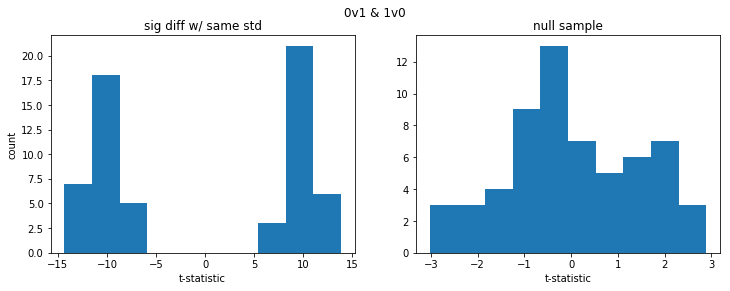

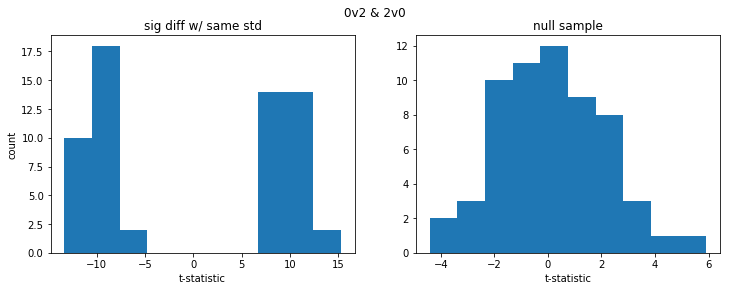

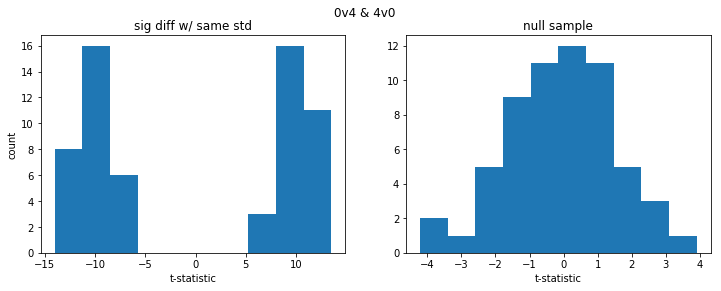

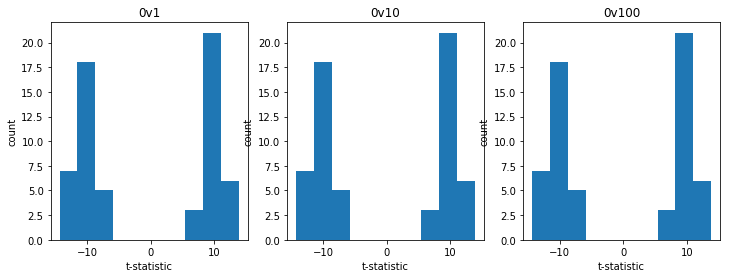

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

pareto_index = 0
expr = 'float_div(array_median(array_sub_float(x1, array_mean(x2))), array_stderr(x2))'
#'float_square(float_div(float_square(float_square(array_median(array_sub_float(x1, array_mean(x2))))), array_mean(array_add_float(array_square(array_square(x1)), array_mean(x1)))))'
#'float_div(array_sum(array_sub_float(x2, array_mean(x1))), array_std(x1))'
#'array_var(array_mul_float(x1, array_mean(array_div_float(array_sub_float(x1, array_mean(x2)), array_var(x2)))))'
#'float_div(float_sub(array_mean(x1), array_mean(x2)), array_std(x1))'
#'float_div(array_median(array_sub_float(x2, array_median(x1))), array_std(x2))'
#'array_mean(array_div_float(array_sub_float(x2, array_mean(x1)), array_var(array_sqrt(x1))))'
#'float_div(array_median(array_sub_float(x2, array_median(x1))), array_min(x1))'
#'array_median(array_sub_float(array_div_float(x2, array_median(x1)), 1.0))'

print(expr)
print('')
func = toolbox.compile(expr=expr)

### 0v1 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v1 & 1v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1_same_std, sig_diff_samples_1v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 2, 1)
plt.title('sig diff w/ same std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ same std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v1_same_std[0], null_samples_0v1_same_std[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.subplot(1, 2, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

### 0v2 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v2 & 2v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v2_same_std, sig_diff_samples_2v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 2, 1)
plt.title('sig diff w/ same std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ same std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v2_same_std[0], null_samples_0v2_same_std[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 2, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

### 0v4 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v4 & 4v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v4_same_std, sig_diff_samples_4v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 2, 1)
plt.title('sig diff w/ same std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ same std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v4_same_std[0], null_samples_0v4_same_std[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 2, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')


### 0v1 & 0v10 & 0v100 ###

plt.figure(figsize=(12, 4))

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1_same_std, sig_diff_samples_1v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('0v1')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='0v1')


t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10_same_std, sig_diff_samples_10v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 2)
plt.title('0v10')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='0v10')


t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('0v100')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='0v100')
;

# Plots for paper

float_div(array_median(array_sub_float(x1, array_mean(x2))), array_stderr(x2))

float_square(float_div(float_square(float_square(array_median(array_sub_float(x1, array_mean(x2))))), array_mean(array_add_float(array_square(array_square(x1)), array_mean(x1)))))

float_div(array_sum(array_sub_float(x2, array_mean(x1))), array_std(x1))

array_var(array_mul_float(x1, array_mean(array_div_float(array_sub_float(x1, array_mean(x2)), array_var(x2)))))

float_div(float_sub(array_mean(x1), array_mean(x2)), array_std(x1))

float_div(array_median(array_sub_float(x2, array_median(x1))), array_std(x2))

float_div(array_median(array_sub_float(x2, array_median(x1))), array_min(x1))

array_median(array_sub_float(array_div_float(x2, array_median(x1)), 1.0))



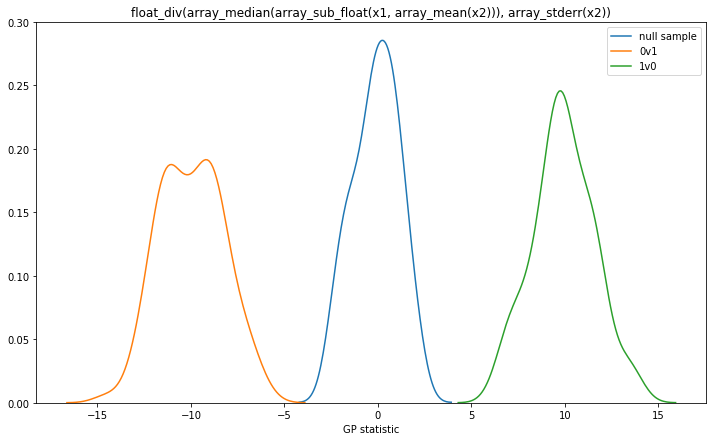

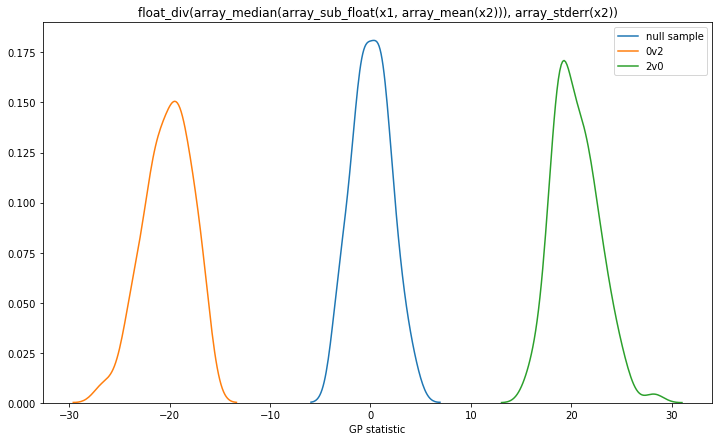

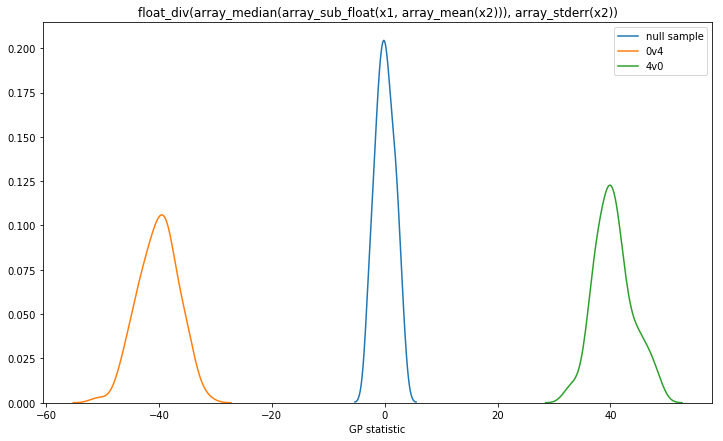

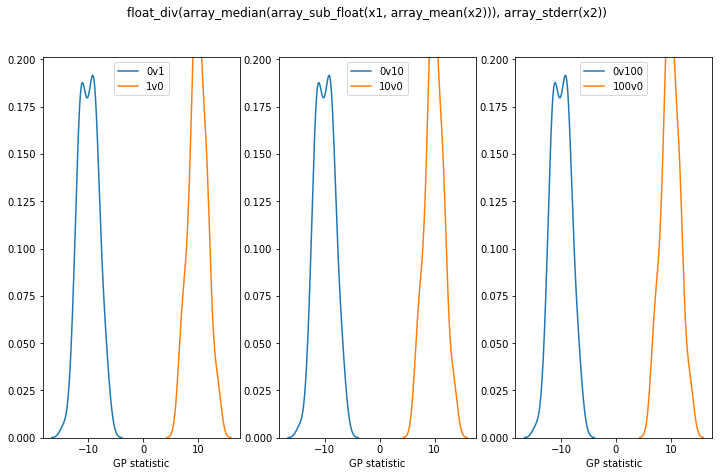

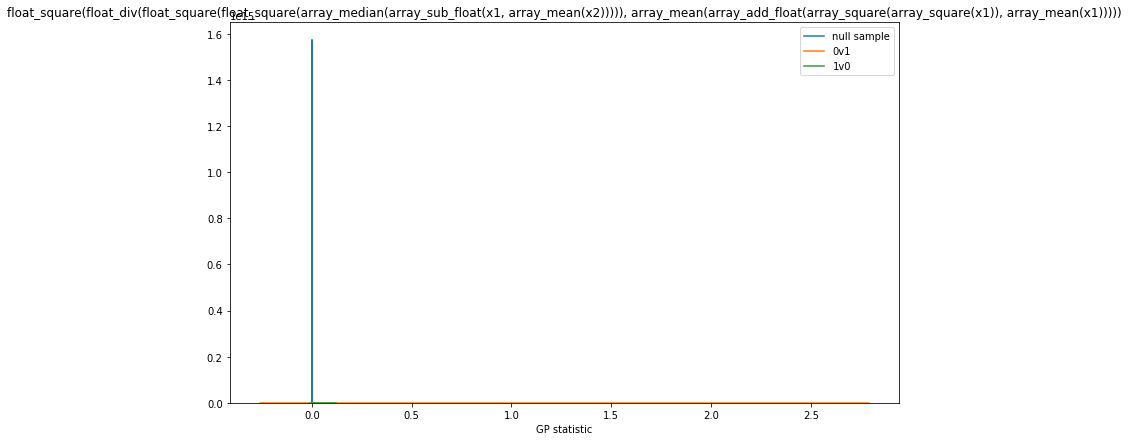

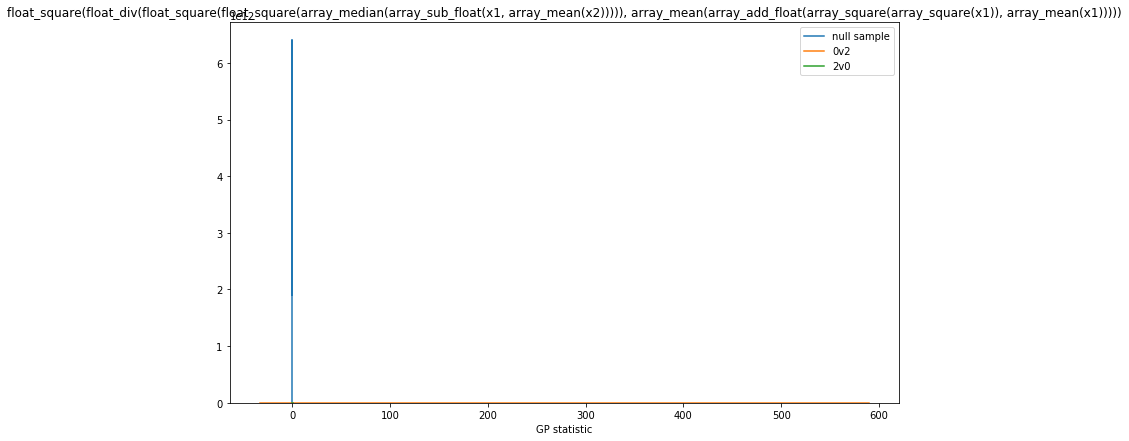

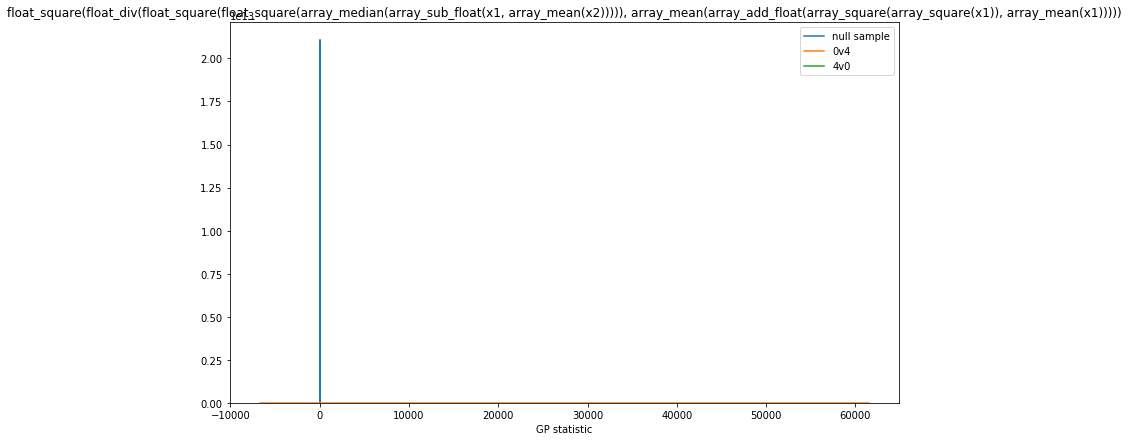

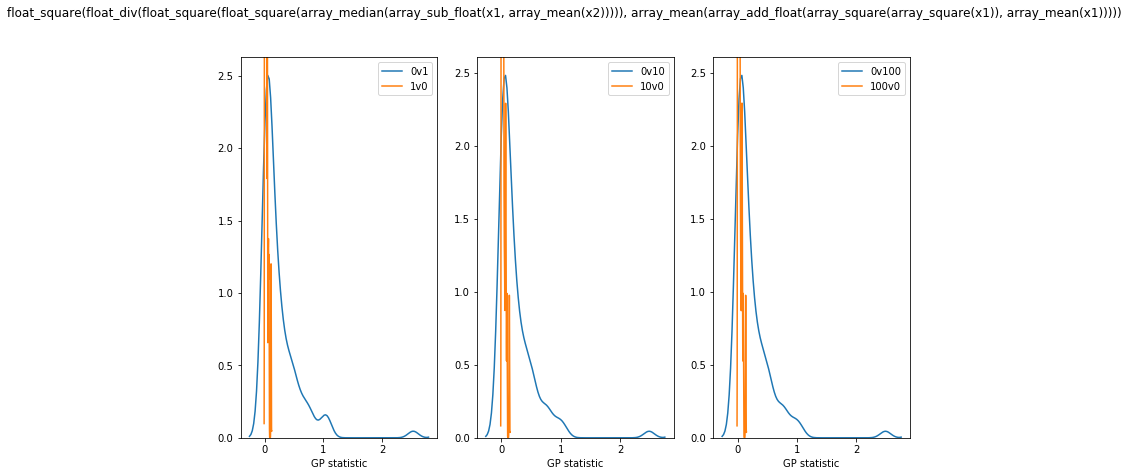

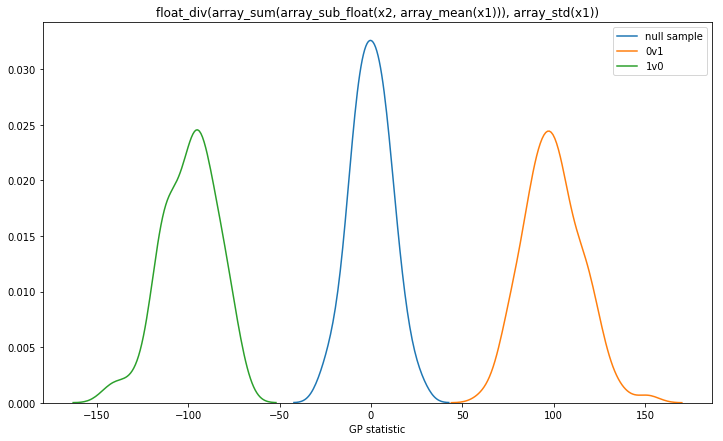

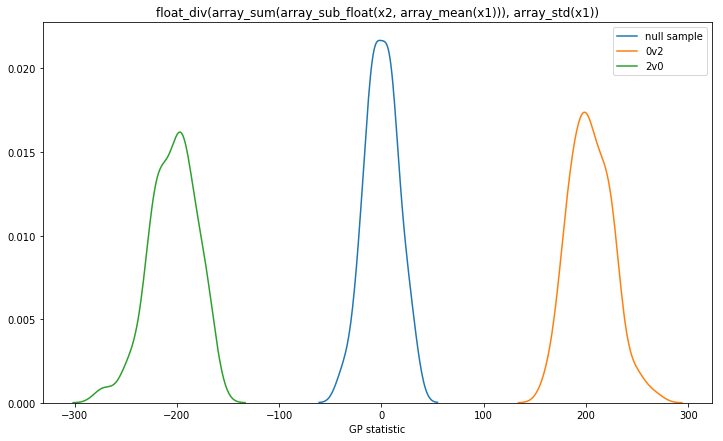

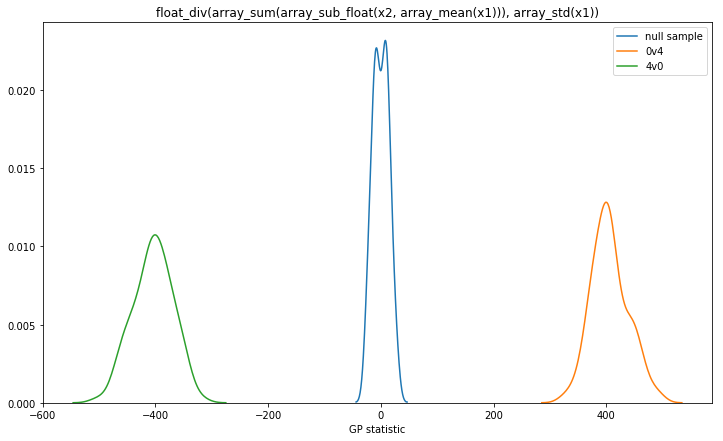

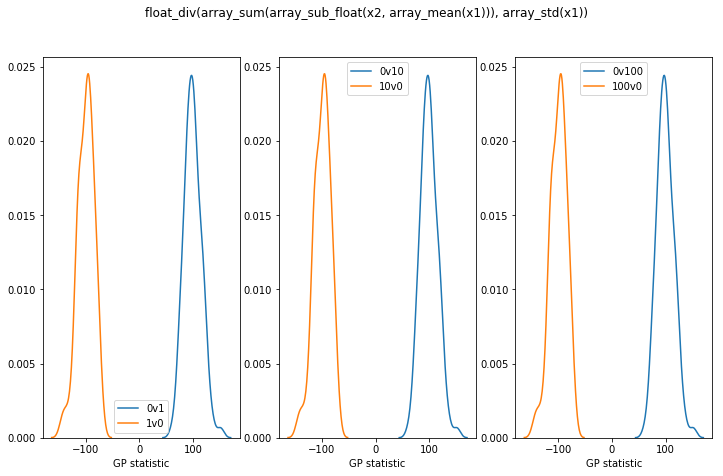

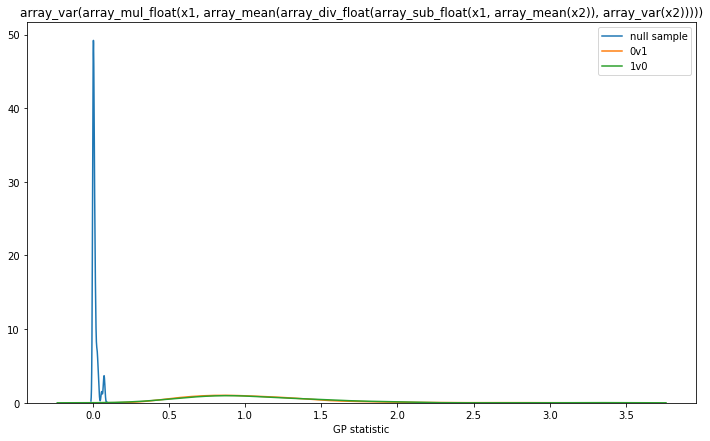

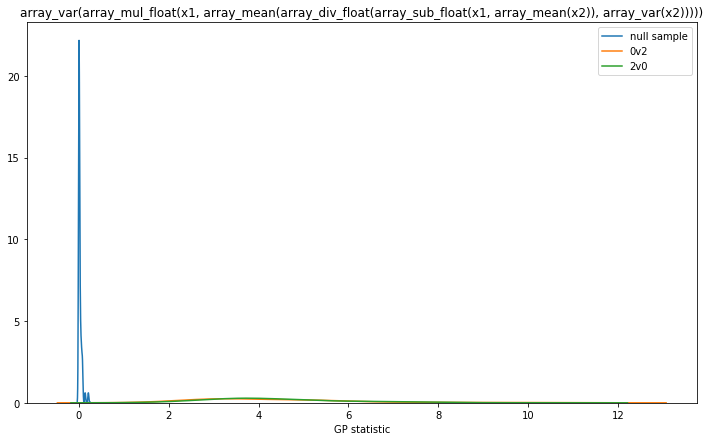

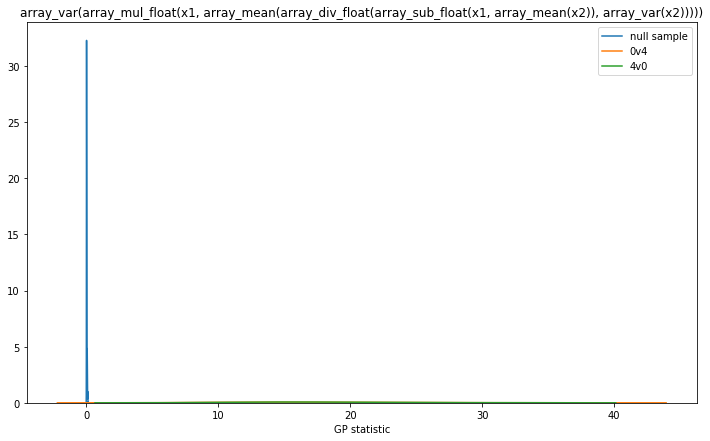

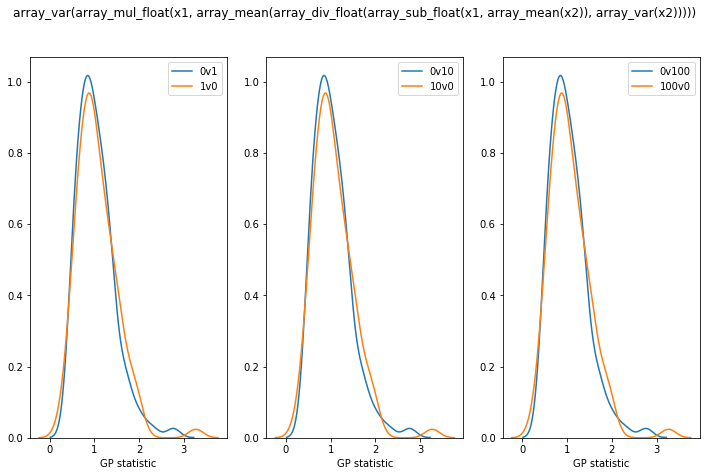

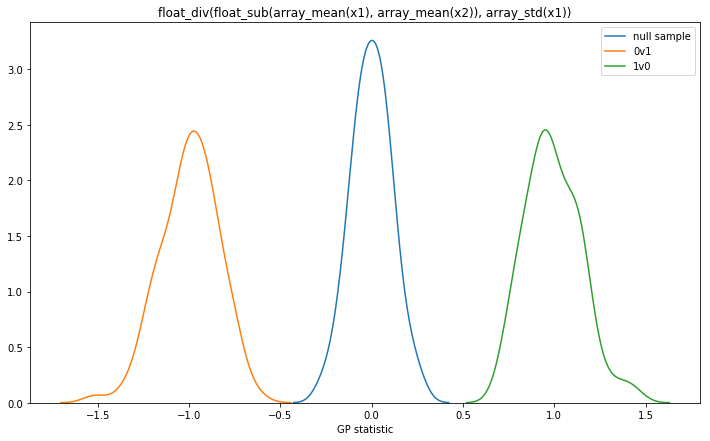

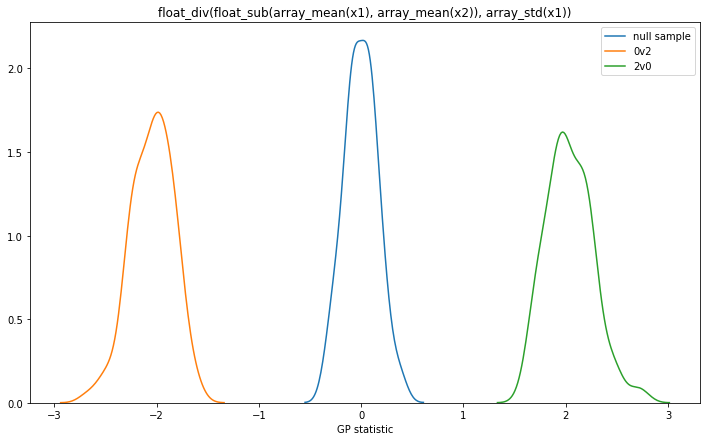

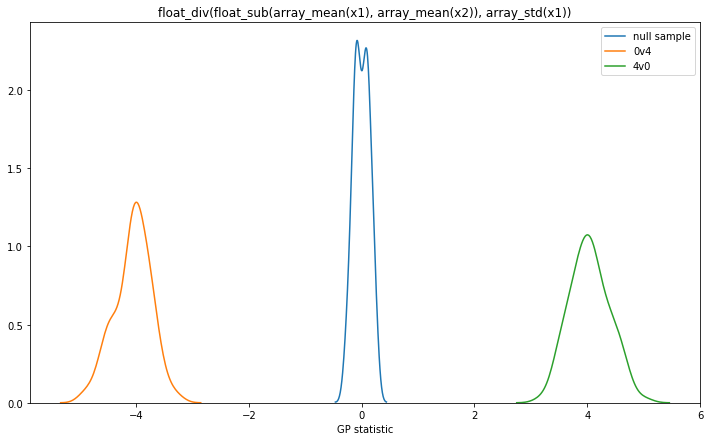

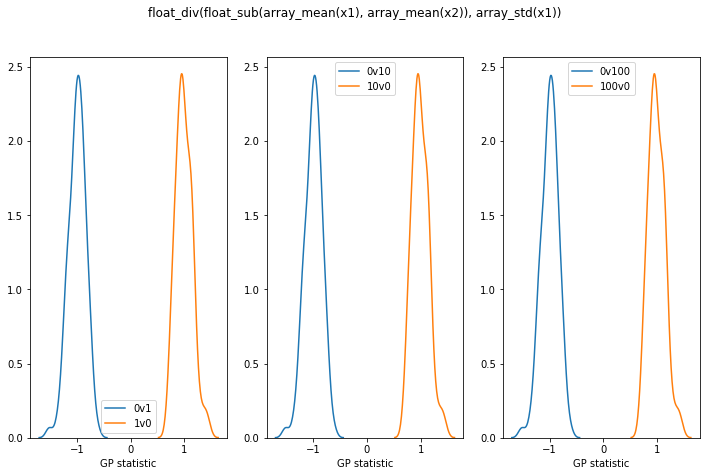

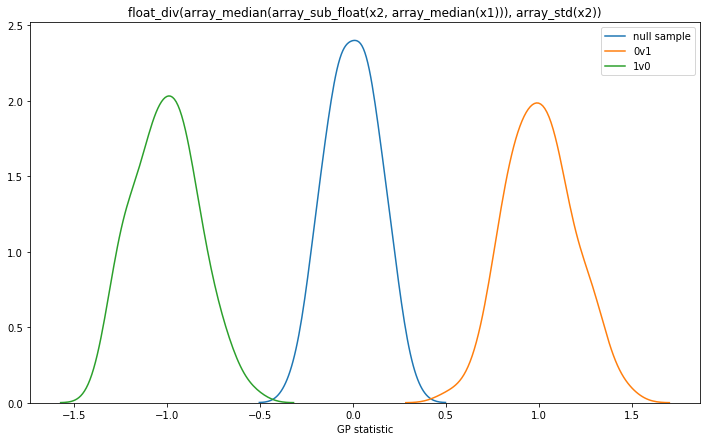

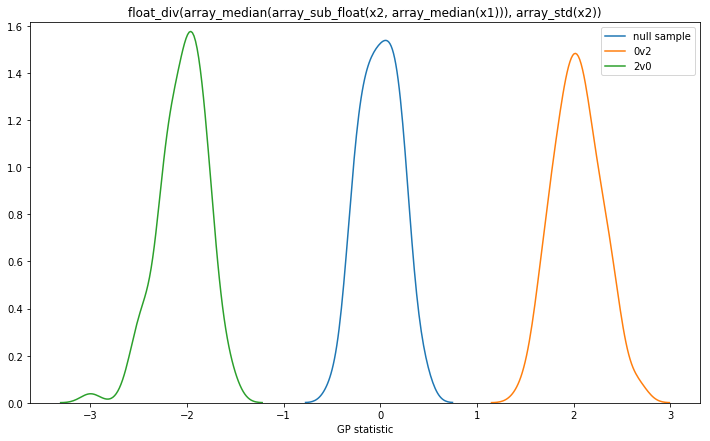

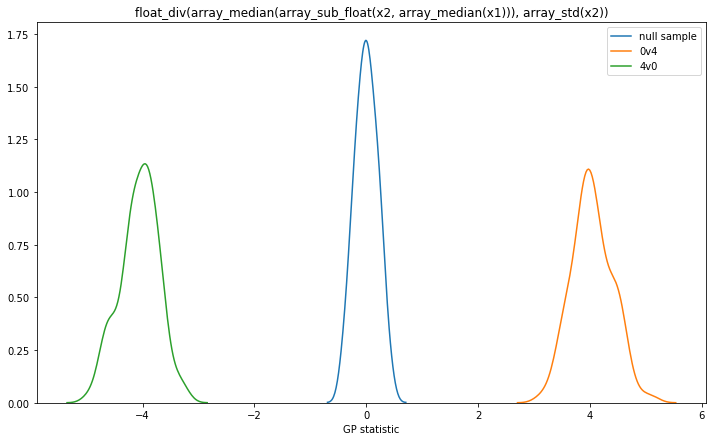

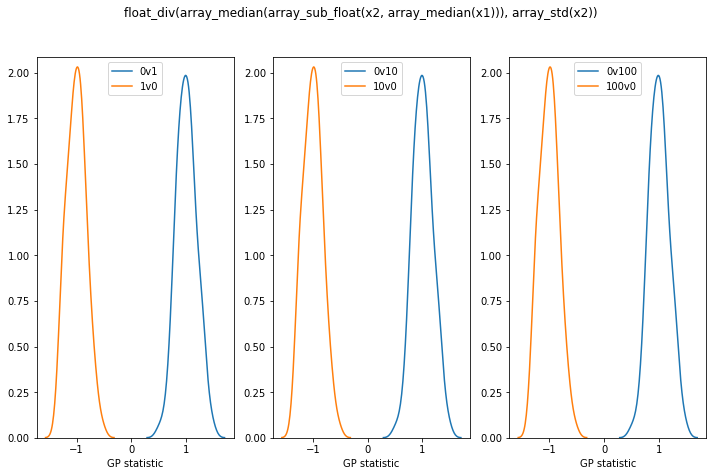

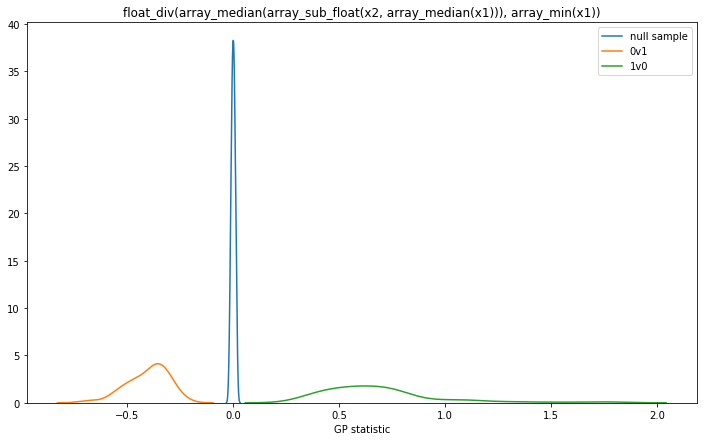

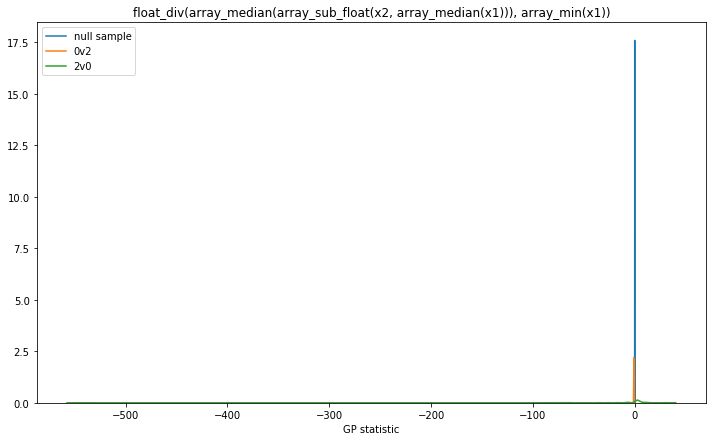

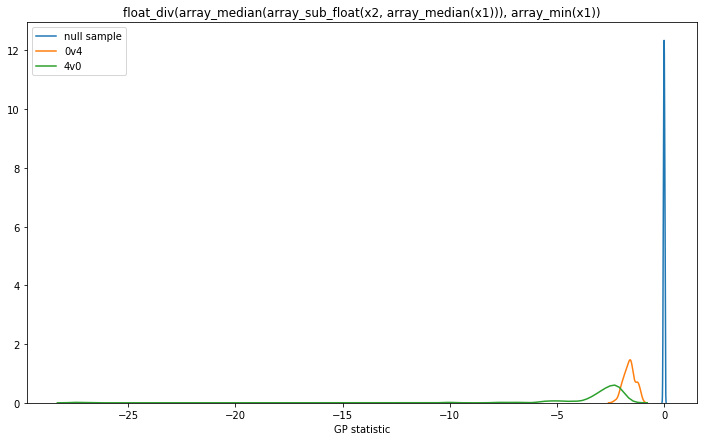

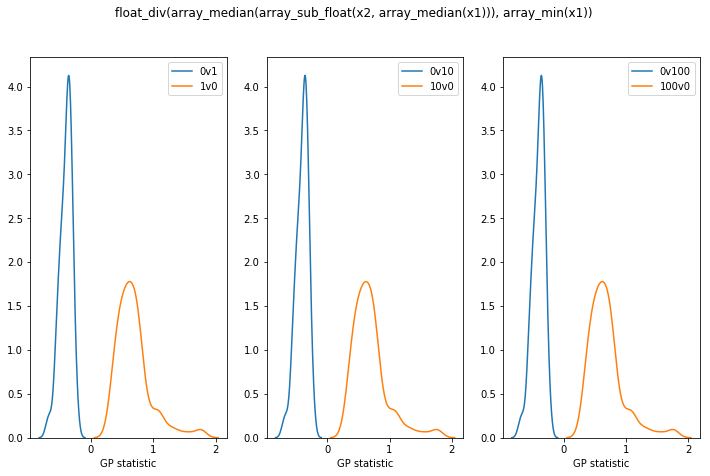

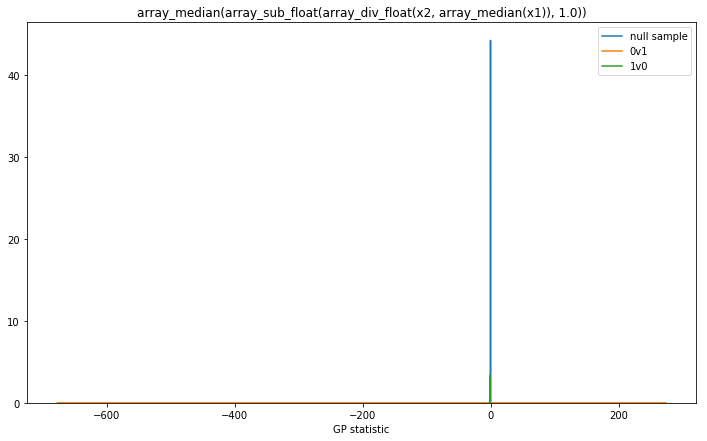

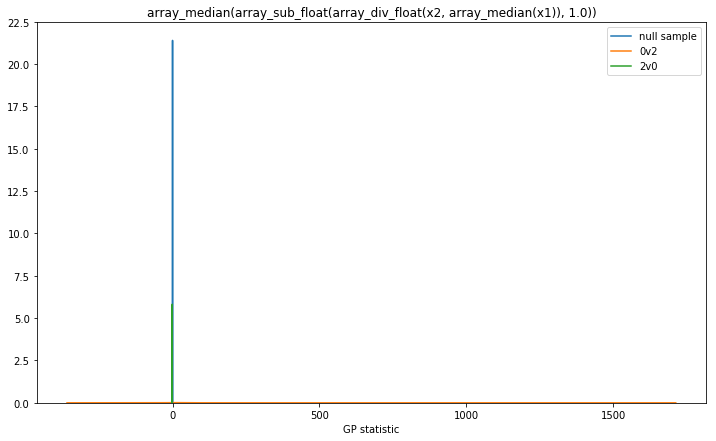

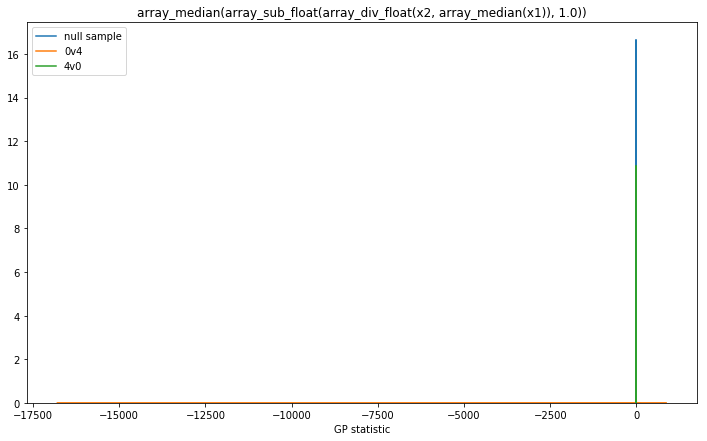

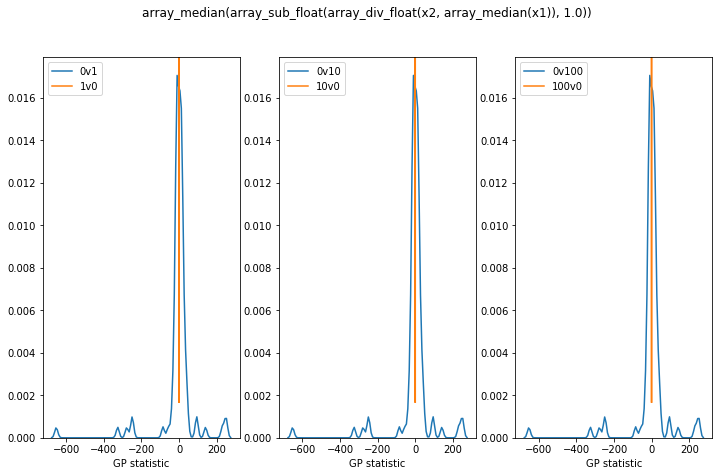

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import ttest_ind


# Simulate larger datasets
sig_diff_samples_0v1_same_std = np.random.normal(loc=0, scale=1, size=(100, 100))
sig_diff_samples_1v0_same_std = np.random.normal(loc=1, scale=1, size=(100, 100))

sig_diff_samples_0v2_same_std = np.random.normal(loc=0, scale=1, size=(100, 100))
sig_diff_samples_2v0_same_std = np.random.normal(loc=2, scale=1, size=(100, 100))

sig_diff_samples_0v4_same_std = np.random.normal(loc=0, scale=1, size=(100, 100))
sig_diff_samples_4v0_same_std = np.random.normal(loc=4, scale=1, size=(100, 100))

# Sample distributions for scale invariance metric
sig_diff_samples_0v10_same_std = sig_diff_samples_0v1_same_std * 10.
sig_diff_samples_10v0_same_std = sig_diff_samples_1v0_same_std * 10.

sig_diff_samples_0v100_same_std = sig_diff_samples_0v1_same_std * 100.
sig_diff_samples_100v0_same_std = sig_diff_samples_1v0_same_std * 100.



evolved_stats = ['float_div(array_median(array_sub_float(x1, array_mean(x2))), array_stderr(x2))',
                 'float_square(float_div(float_square(float_square(array_median(array_sub_float(x1, array_mean(x2))))), array_mean(array_add_float(array_square(array_square(x1)), array_mean(x1)))))',
                 'float_div(array_sum(array_sub_float(x2, array_mean(x1))), array_std(x1))',
                 'array_var(array_mul_float(x1, array_mean(array_div_float(array_sub_float(x1, array_mean(x2)), array_var(x2)))))',
                 'float_div(float_sub(array_mean(x1), array_mean(x2)), array_std(x1))',
                 'float_div(array_median(array_sub_float(x2, array_median(x1))), array_std(x2))',
                 #'array_mean(array_div_float(array_sub_float(x2, array_mean(x1)), array_var(array_sqrt(x1))))',
                 'float_div(array_median(array_sub_float(x2, array_median(x1))), array_min(x1))',
                 'array_median(array_sub_float(array_div_float(x2, array_median(x1)), 1.0))']

for expr in evolved_stats:

    print(expr)
    print('')
    func = toolbox.compile(expr=expr)

    ### 0v1 ###

    plt.figure(figsize=(12, 7))
    plt.title(expr)
    
    t_vals = []
    for sample1, sample2 in zip(null_samples_0v1_same_std[0], null_samples_0v1_same_std[1]):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    sb.distplot(t_vals, label='null sample', hist=False)

    t_vals = []
    for sample1, sample2 in zip(sig_diff_samples_0v1_same_std, sig_diff_samples_1v0_same_std):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    sb.distplot(t_vals[::2], label='0v1', hist=False)
    sb.distplot(t_vals[1::2], label='1v0', hist=False)
    plt.xlabel('GP statistic')

    ### 0v2 ###

    plt.figure(figsize=(12, 7))
    plt.title(expr)
    
    t_vals = []
    for sample1, sample2 in zip(null_samples_0v2_same_std[0], null_samples_0v2_same_std[1]):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    sb.distplot(t_vals, label='null sample', hist=False)

    t_vals = []
    for sample1, sample2 in zip(sig_diff_samples_0v2_same_std, sig_diff_samples_2v0_same_std):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    sb.distplot(t_vals[::2], label='0v2', hist=False)
    sb.distplot(t_vals[1::2], label='2v0', hist=False)
    plt.xlabel('GP statistic')

    ### 0v4 ###

    plt.figure(figsize=(12, 7))
    plt.title(expr)
    
    t_vals = []
    for sample1, sample2 in zip(null_samples_0v4_same_std[0], null_samples_0v4_same_std[1]):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    sb.distplot(t_vals, label='null sample', hist=False)

    t_vals = []
    for sample1, sample2 in zip(sig_diff_samples_0v4_same_std, sig_diff_samples_4v0_same_std):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    sb.distplot(t_vals[::2], label='0v4', hist=False)
    sb.distplot(t_vals[1::2], label='4v0', hist=False)
    plt.xlabel('GP statistic')


    ### 0v1 & 0v10 & 0v100 ###

    plt.figure(figsize=(12, 7))
    plt.suptitle(expr)

    t_vals = []
    for sample1, sample2 in zip(sig_diff_samples_0v1_same_std, sig_diff_samples_1v0_same_std):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    plt.subplot(1, 3, 1)
    plt.xlabel('GP statistic')
    sb.distplot(t_vals[::2], label='0v1', hist=False)
    sb.distplot(t_vals[1::2], label='1v0', hist=False)


    t_vals = []
    for sample1, sample2 in zip(sig_diff_samples_0v10_same_std, sig_diff_samples_10v0_same_std):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    plt.subplot(1, 3, 2)
    plt.xlabel('GP statistic')
    sb.distplot(t_vals[::2], label='0v10', hist=False)
    sb.distplot(t_vals[1::2], label='10v0', hist=False)


    t_vals = []
    for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
        t_vals.append(func(sample1, sample2))
        t_vals.append(func(sample2, sample1))

    plt.subplot(1, 3, 3)
    plt.xlabel('GP statistic')
    sb.distplot(t_vals[::2], label='0v100', hist=False)
    sb.distplot(t_vals[1::2], label='100v0', hist=False)


float_div(array_median(array_sub_float(x1, array_mean(x2))), array_stderr(x2))

float_square(float_div(float_square(float_square(array_median(array_sub_float(x1, array_mean(x2))))), array_mean(array_add_float(array_square(array_square(x1)), array_mean(x1)))))

float_div(array_sum(array_sub_float(x2, array_mean(x1))), array_std(x1))

array_var(array_mul_float(x1, array_mean(array_div_float(array_sub_float(x1, array_mean(x2)), array_var(x2)))))

float_div(float_sub(array_mean(x1), array_mean(x2)), array_std(x1))

float_div(array_median(array_sub_float(x2, array_median(x1))), array_std(x2))

float_div(array_median(array_sub_float(x2, array_median(x1))), array_min(x1))

array_median(array_sub_float(array_div_float(x2, array_median(x1)), 1.0))



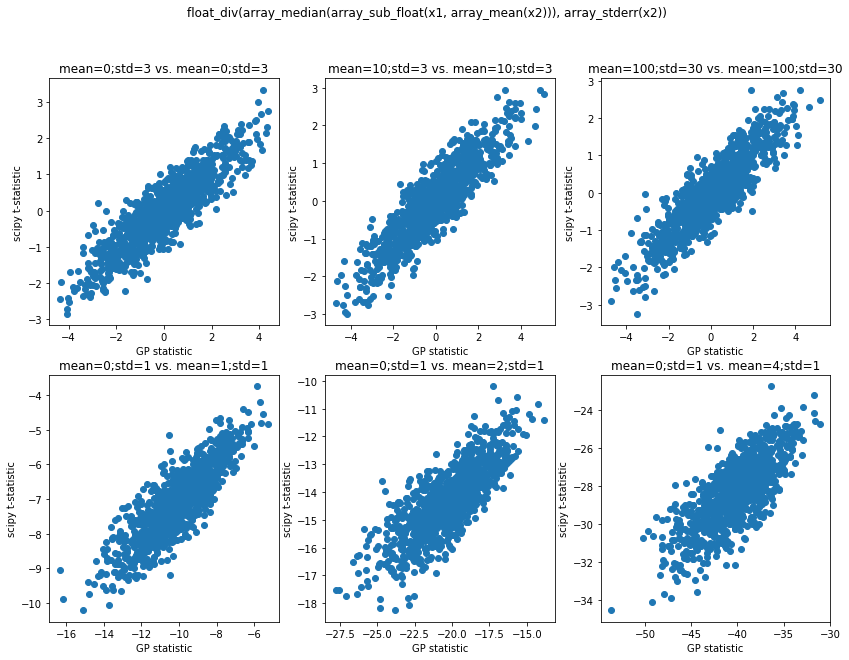

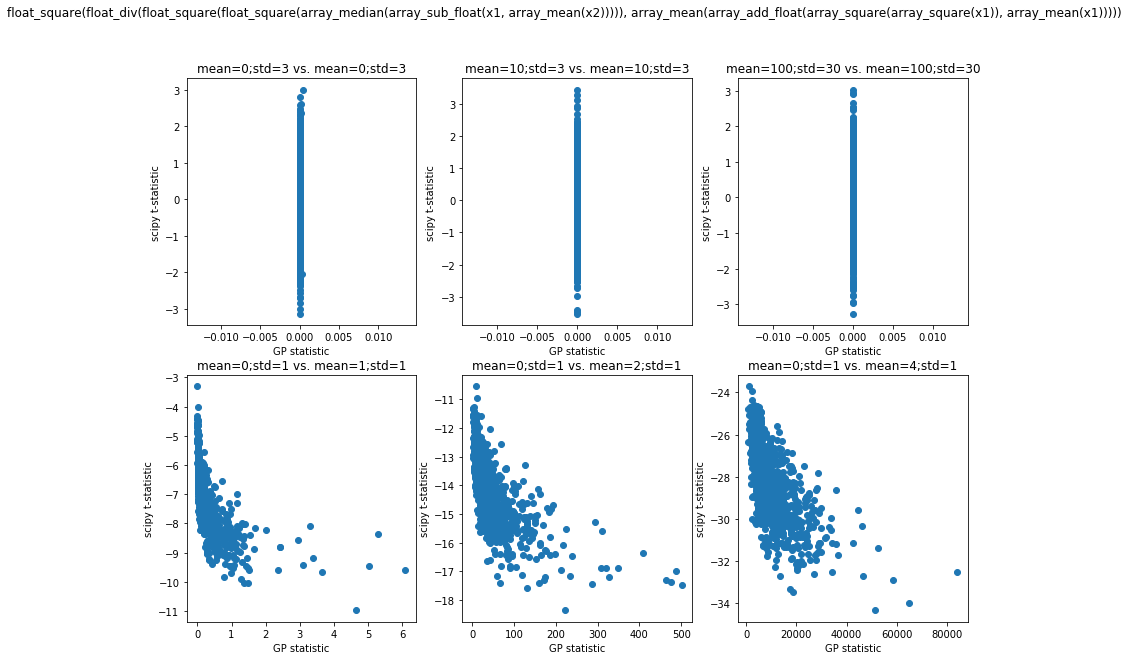

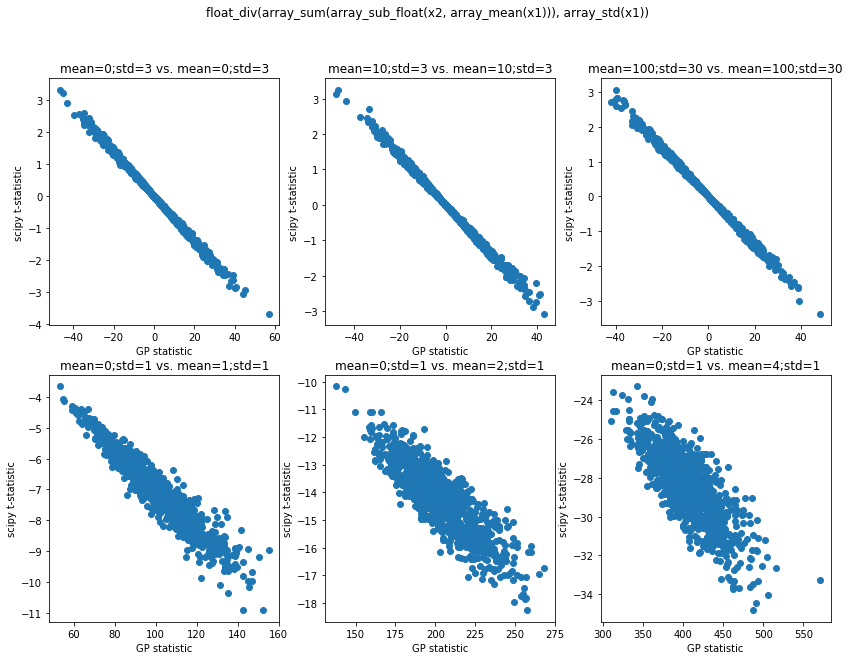

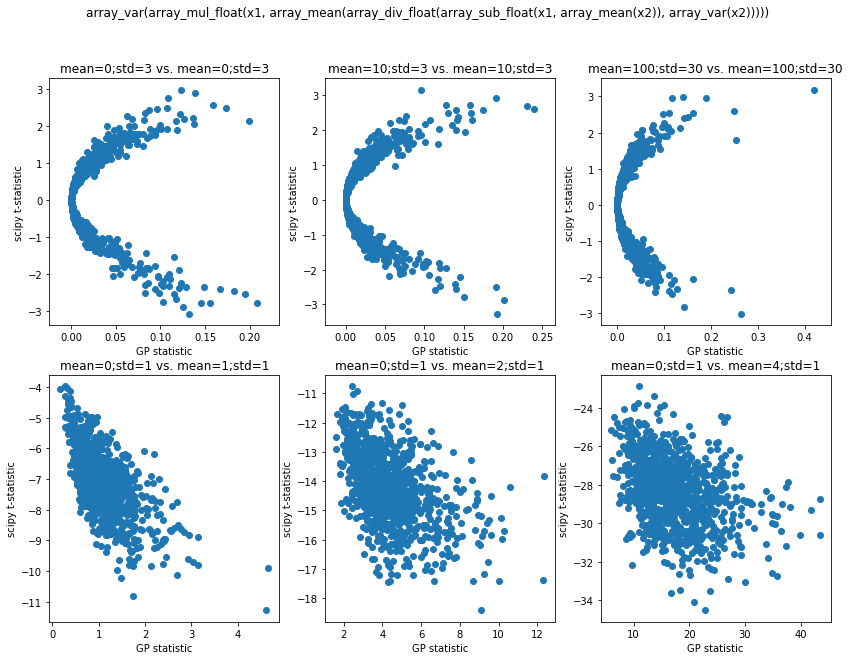

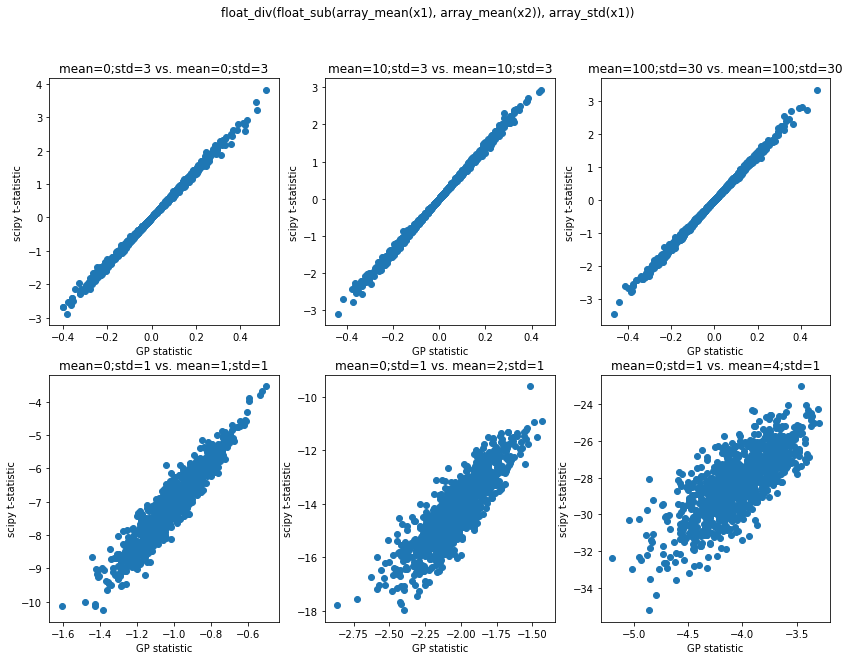

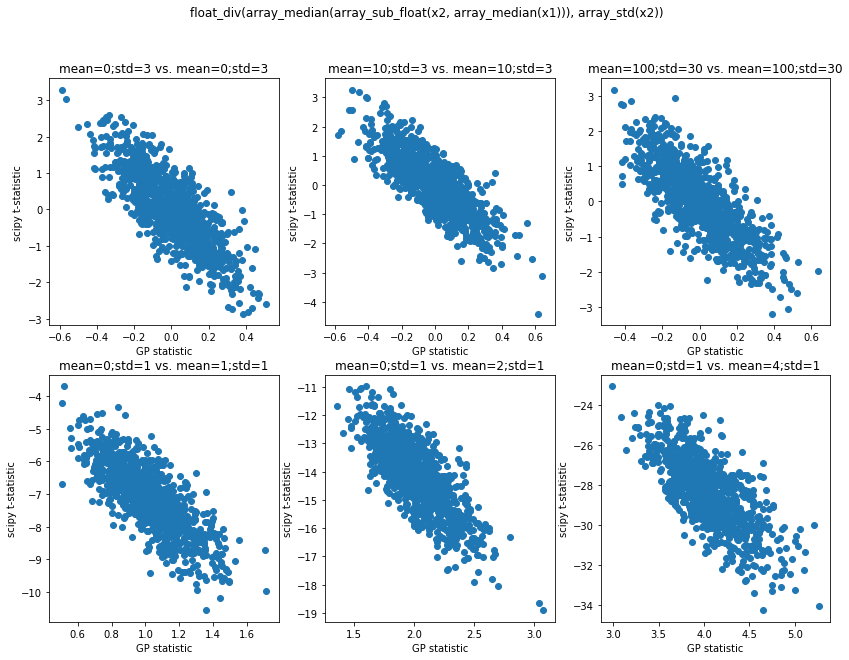

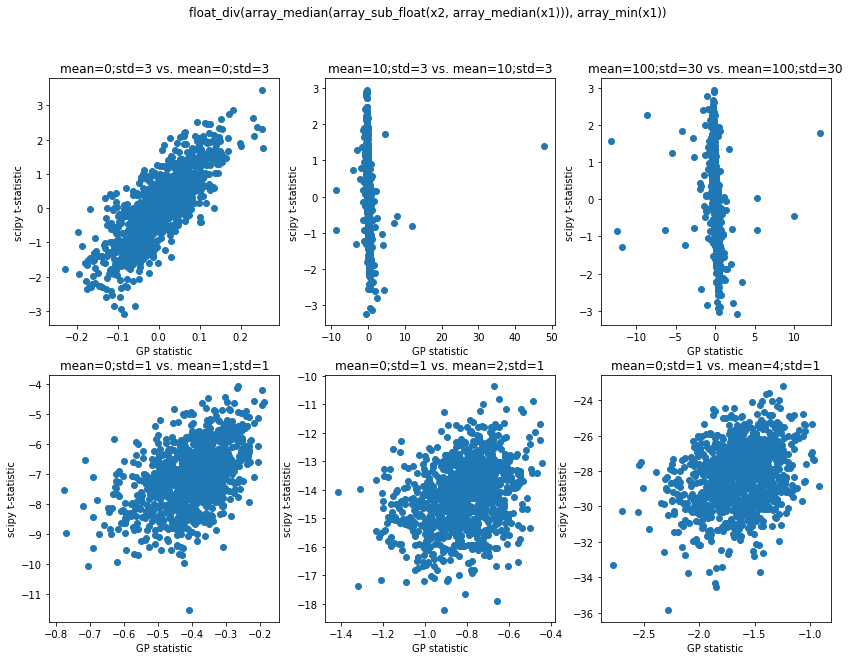

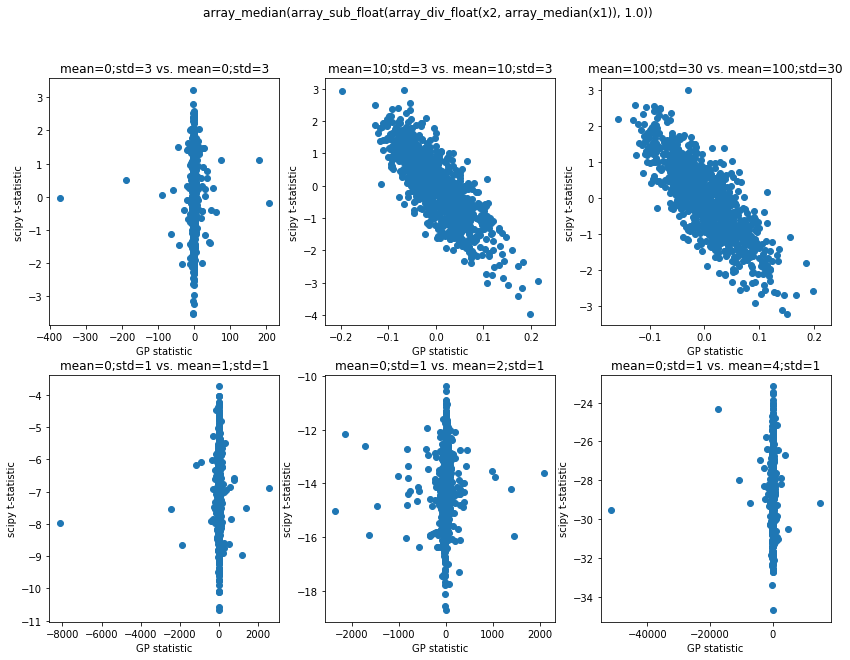

In [56]:
evolved_stats = ['float_div(array_median(array_sub_float(x1, array_mean(x2))), array_stderr(x2))',
                 'float_square(float_div(float_square(float_square(array_median(array_sub_float(x1, array_mean(x2))))), array_mean(array_add_float(array_square(array_square(x1)), array_mean(x1)))))',
                 'float_div(array_sum(array_sub_float(x2, array_mean(x1))), array_std(x1))',
                 'array_var(array_mul_float(x1, array_mean(array_div_float(array_sub_float(x1, array_mean(x2)), array_var(x2)))))',
                 'float_div(float_sub(array_mean(x1), array_mean(x2)), array_std(x1))',
                 'float_div(array_median(array_sub_float(x2, array_median(x1))), array_std(x2))',
                 #'array_mean(array_div_float(array_sub_float(x2, array_mean(x1)), array_var(array_sqrt(x1))))',
                 'float_div(array_median(array_sub_float(x2, array_median(x1))), array_min(x1))',
                 'array_median(array_sub_float(array_div_float(x2, array_median(x1)), 1.0))']

for expr in evolved_stats:
    print(expr)
    print('')
    func = toolbox.compile(expr=expr)

    def plot_test_dist(stat_func, loc1, loc2, std1=1, std2=1):
        stat_dist = []
        ttest_dist = []
        for rep in range(1000):
            dist1 = np.random.normal(loc=loc1, scale=std1, size=100)
            dist2 = np.random.normal(loc=loc2, scale=std2, size=100)
            stat_dist.append(stat_func(dist1, dist2))
            ttest_dist.append(ttest_ind(dist1, dist2).statistic)
        
        plt.title('mean={};std={} vs. mean={};std={}'.format(loc1, std1, loc2, std2))
        plt.scatter(stat_dist, ttest_dist)
        plt.xlabel('GP statistic')
        plt.ylabel('scipy t-statistic')

    plt.figure(figsize=(14, 10))
    plt.suptitle(expr)
    # Same mean, same std
    plt.subplot(2, 3, 1)
    plot_test_dist(func, 0, 0, std1=3, std2=3)
    plt.subplot(2, 3, 2)
    plot_test_dist(func, 10, 10, std1=3, std2=3)
    plt.subplot(2, 3, 3)
    plot_test_dist(func, 100, 100, std1=30, std2=30)

    # Diff mean, same std
    plt.subplot(2, 3, 4)
    plot_test_dist(func, 0, 1, std1=1, std2=1)
    plt.subplot(2, 3, 5)
    plot_test_dist(func, 0, 2, std1=1, std2=1)
    plt.subplot(2, 3, 6)
    plot_test_dist(func, 0, 4, std1=1, std2=1)

## Visualize specific solution

/Users/randal_olson/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


float_div(float_sqrt(1.0), array_std(x2))



''

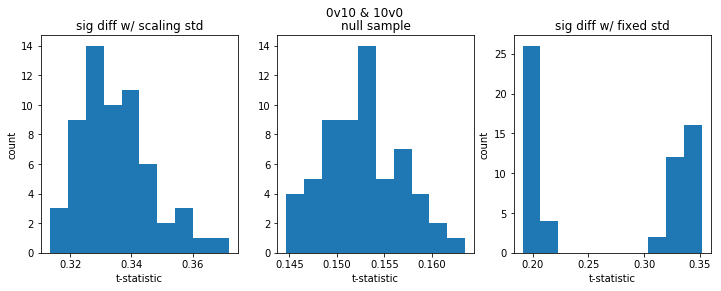

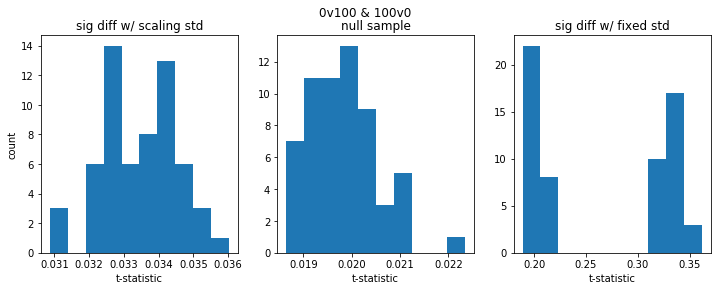

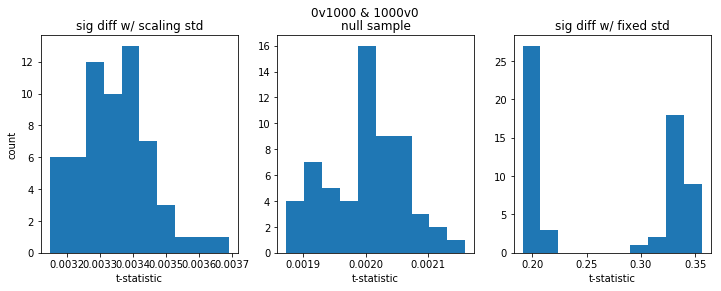

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


solution = 'float_div(float_sqrt(1.0), array_std(x2))'

print(solution)
print('')
func = toolbox.compile(expr=solution)

### 0v10 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v10 & 10v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10_same_std, sig_diff_samples_10v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v10[0], null_samples_0v10[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ fixed std')

### 0v100 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v100 & 100v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v100[0], null_samples_0v100[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100, sig_diff_samples_100v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='sig diff w/ fixed std')

### 0v1000 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v1000 & 1000v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1000_same_std, sig_diff_samples_1000v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v1000[0], null_samples_0v1000[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1000, sig_diff_samples_1000v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='sig diff w/ fixed std')
;

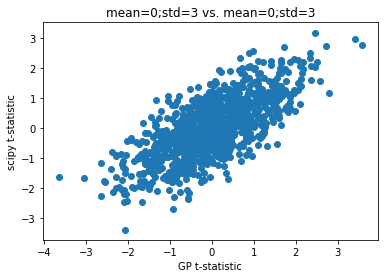

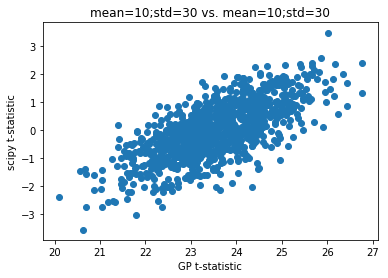

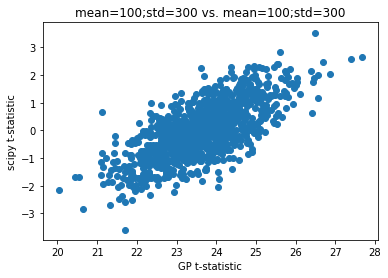

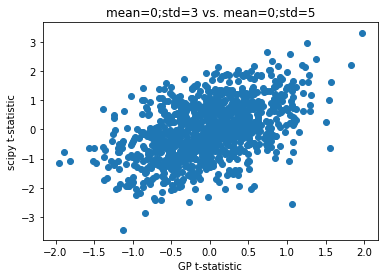

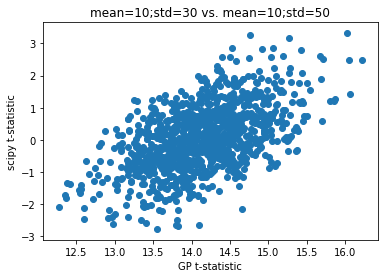

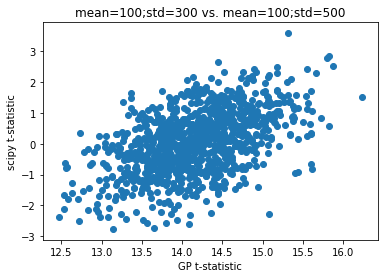

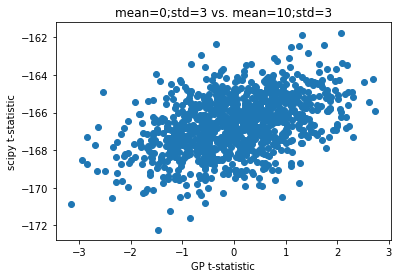

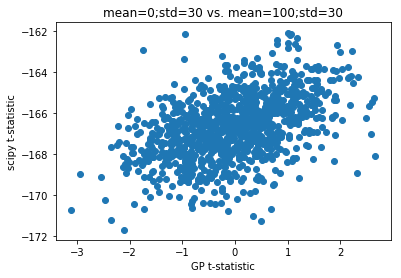

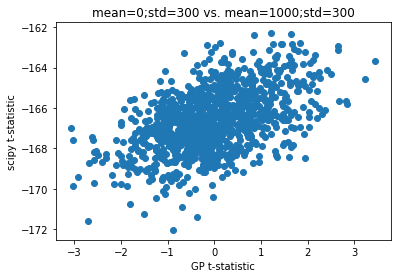

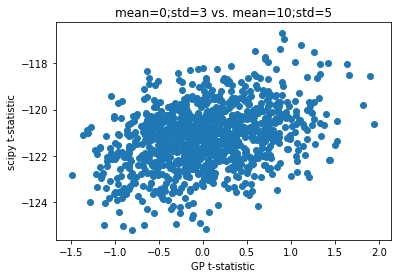

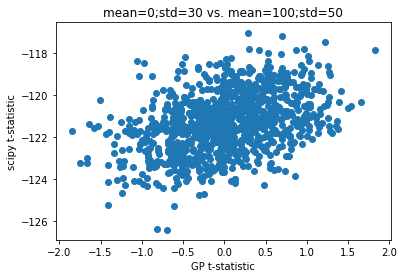

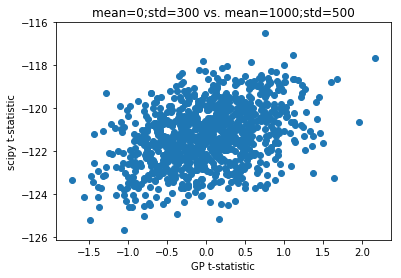

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np

def plot_test_dist(stat_func, loc1, loc2, std1=3, std2=3):
    stat_dist = []
    ttest_dist = []
    for rep in range(1000):
        dist1 = np.random.normal(loc=loc1, scale=std1, size=5000)
        dist2 = np.random.normal(loc=loc2, scale=std2, size=5000)
        stat_dist.append(stat_func(dist1, dist2))
        ttest_dist.append(ttest_ind(dist1, dist2).statistic)
    plt.figure()
    plt.title('mean={};std={} vs. mean={};std={}'.format(loc1, std1, loc2, std2))
    plt.scatter(stat_dist, ttest_dist)
    plt.xlabel('GP t-statistic')
    plt.ylabel('scipy t-statistic')

# Same mean, same std
plot_test_dist(func, 0, 0, std1=3, std2=3)
plot_test_dist(func, 10, 10, std1=30, std2=30)
plot_test_dist(func, 100, 100, std1=300, std2=300)

# Same mean, diff std
plot_test_dist(func, 0, 0, std1=3, std2=5)
plot_test_dist(func, 10, 10, std1=30, std2=50)
plot_test_dist(func, 100, 100, std1=300, std2=500)

# Diff mean, same std
plot_test_dist(func, 0, 10, std1=3, std2=3)
plot_test_dist(func, 0, 100, std1=30, std2=30)
plot_test_dist(func, 0, 1000, std1=300, std2=300)

# Diff mean, diff std
plot_test_dist(func, 0, 10, std1=3, std2=5)
plot_test_dist(func, 0, 100, std1=30, std2=50)
plot_test_dist(func, 0, 1000, std1=300, std2=500)

# Look at the evolutionary path to the t-test

In [9]:
for ttest_str in ['float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_div(float_add(array_var(x1), array_var(x2)), array_size(x1))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_div(float_add(array_var(x1), array_var(x2)), array_size(x1)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_var(x1), array_var(x2)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_div(array_var(x1), array_size(x1)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_std(x1), array_std(x2)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_var(x1))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_std(x1))',
                  'float_sub(array_mean(x1), array_mean(x2))']:
    t_test = creator.Individual.from_string(ttest_str, pset)
    print('{}: {}'.format(evaluate_individual(t_test), ttest_str))

print('')

for ttest_str in ['float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_stderr(x1), array_stderr(x2)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_stderr(x1))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_stderr(x2))',]:
    t_test = creator.Individual.from_string(ttest_str, pset)
    print('{}: {}'.format(evaluate_individual(t_test), ttest_str))

(1.0, 0.69999999999999996, 319, 6): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))
(1.0, 0.69999999999999996, 319, 5): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_div(float_add(array_var(x1), array_var(x2)), array_size(x1))))
(1.0, 15.9, 14, 4): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))
(0.98999999999999999, 0.10000000000000001, 33313, 5): float_div(float_sub(array_mean(x1), array_mean(x2)), float_div(float_add(array_var(x1), array_var(x2)), array_size(x1)))
(1.0, 15.9, 14, 4): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))
(1.0, 30.0, 66, 4): float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_var(x1), array_var(x2)))
(0.97999999999999998, 0.0, 66760, 4): float_div(float_sub(array_mean(x1), array_mean(x2)), flo

## Compare distributions of GP t-test vs. scipy t-test

''

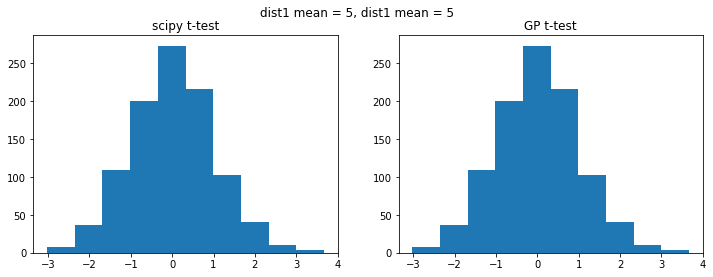

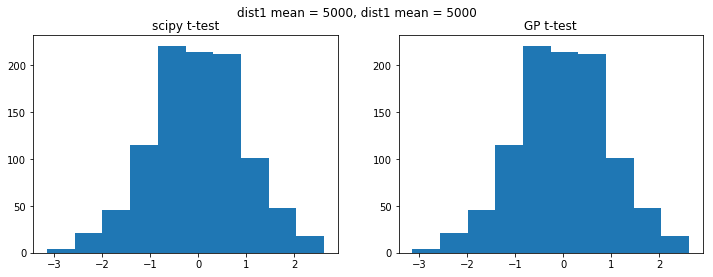

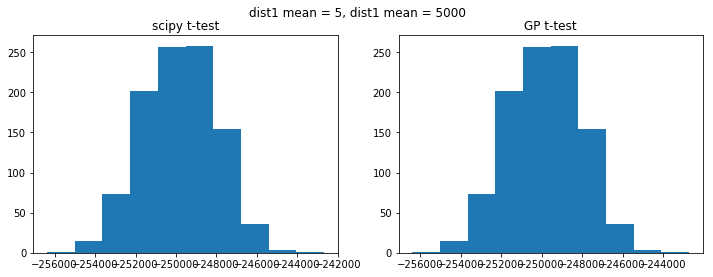

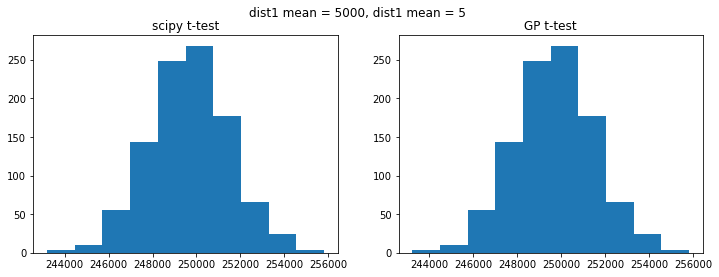

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

stat_str = 'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))'
#'array_median(array_div(array_add(x1, array_add_float(array_div(x1, x2), array_std(x2))), array_add(x2, x1)))'
#'array_median(array_sub(x1, array_sub_float(x2, float_sqrt(array_std(x2)))))'
stat_ind = creator.Individual.from_string(stat_str, pset)
stat_func = toolbox.compile(expr=stat_ind)

def plot_test_dist(loc1, loc2):
    stat_dist = []
    ttest_dist = []
    for rep in range(1000):
        dist1 = np.random.normal(loc=loc1, size=5000)
        dist2 = np.random.normal(loc=loc2, size=5000)
        stat_dist.append(stat_func(dist1, dist2))
        ttest_dist.append(ttest_ind(dist1, dist2).statistic)
    plt.figure(figsize=(12, 4))
    plt.suptitle('dist1 mean = {}, dist1 mean = {}'.format(loc1, loc2))
    ax = plt.subplot(1, 2, 1)
    ax.ticklabel_format(useOffset=False)
    plt.title('scipy t-test')
    plt.hist(ttest_dist)
    ax = plt.subplot(1, 2, 2)
    ax.ticklabel_format(useOffset=False)
    plt.title('GP t-test')
    plt.hist(stat_dist)

plot_test_dist(5, 5)
plot_test_dist(5000, 5000)
plot_test_dist(5, 5000)
plot_test_dist(5000, 5)
;

In [32]:
evolved_test = creator.Individual.from_string('array_median(array_sub(x1, array_sub_float(x2, float_sqrt(array_std(x2)))))', pset)
print('evolved test fitness: {}'.format(evaluate_individual(evolved_test)))

evolved_test = creator.Individual.from_string('array_median(array_sub(array_sub_float(x1, 1.0), array_sub_float(x2, float_sqrt(array_std(x2)))))', pset)
print('evolved test fitness: {}'.format(evaluate_individual(evolved_test)))

evolved test fitness: (0.8846913580246913, 473.14492039930343, 8)
evolved test fitness: (0.8846913580246913, 473.14492039930332, 10)


array_median(array_sub(x1, array_sub_float(x2, float_sqrt(array_std(x2)))))



''

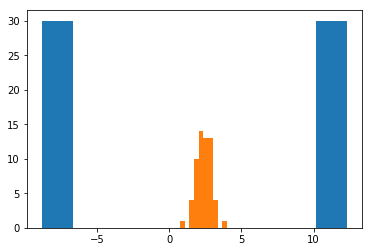

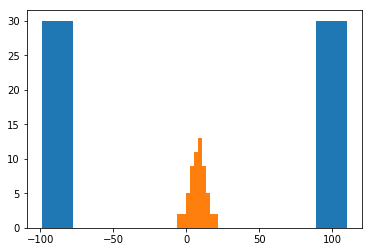

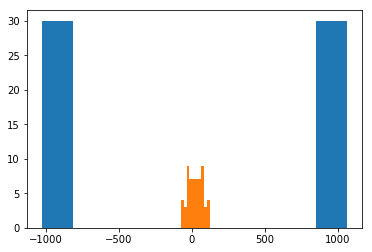

In [43]:
pareto_index = 2

print(pareto_front[pareto_index])
print('')
func = toolbox.compile(expr=pareto_front[pareto_index])

%matplotlib inline
import matplotlib.pyplot as plt

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.figure()
plt.hist(t_vals)

t_vals = []
for sample1, sample2 in zip(null_samples_0v10[0], null_samples_0v10[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.hist(t_vals)




t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100, sig_diff_samples_100v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.figure()
plt.hist(t_vals)

t_vals = []
for sample1, sample2 in zip(null_samples_0v100[0], null_samples_0v100[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.hist(t_vals)





t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1000, sig_diff_samples_1000v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.figure()
plt.hist(t_vals)

t_vals = []
for sample1, sample2 in zip(null_samples_0v1000[0], null_samples_0v1000[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.hist(t_vals)
;

''

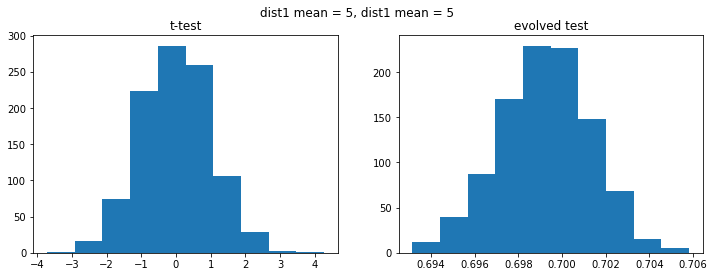

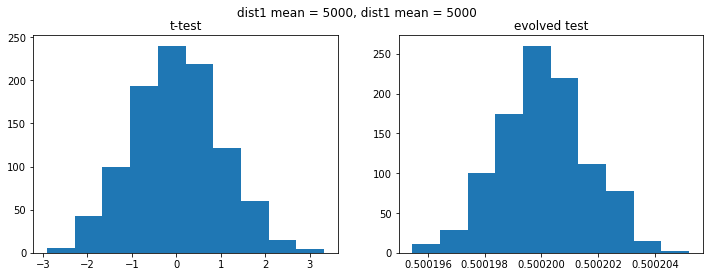

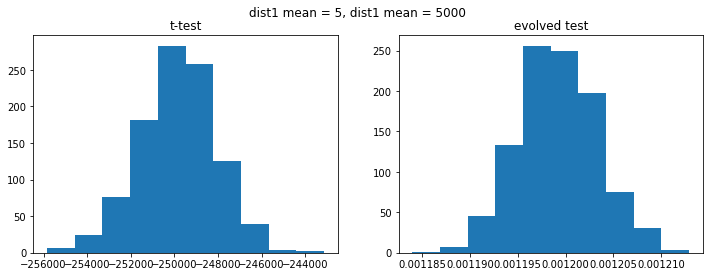

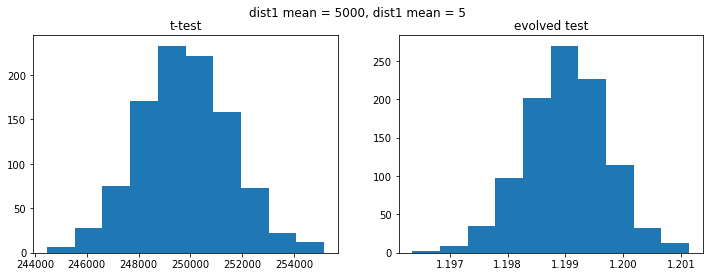

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

stat_str = 'array_median(array_div(array_add(x1, array_add_float(array_div(x1, x2), array_std(x2))), array_add(x2, x1)))'
#'array_median(array_sub(x1, array_sub_float(x2, float_sqrt(array_std(x2)))))'
stat_ind = creator.Individual.from_string(stat_str, pset)
stat_func = toolbox.compile(expr=stat_ind)

def plot_test_dist(loc1, loc2):
    stat_dist = []
    ttest_dist = []
    for rep in range(1000):
        dist1 = np.random.normal(loc=loc1, size=5000)
        dist2 = np.random.normal(loc=loc2, size=5000)
        stat_dist.append(stat_func(dist1, dist2))
        ttest_dist.append(ttest_ind(dist1, dist2).statistic)
    plt.figure(figsize=(12, 4))
    plt.suptitle('dist1 mean = {}, dist1 mean = {}'.format(loc1, loc2))
    ax = plt.subplot(1, 2, 1)
    ax.ticklabel_format(useOffset=False)
    plt.title('t-test')
    plt.hist(ttest_dist)
    ax = plt.subplot(1, 2, 2)
    ax.ticklabel_format(useOffset=False)
    plt.title('evolved test')
    plt.hist(stat_dist)

plot_test_dist(5, 5)
plot_test_dist(5000, 5000)
plot_test_dist(5, 5000)
plot_test_dist(5000, 5)
;